In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import keyedvectors

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Connect to database

In [2]:
#Load database
conn = sqlite3.connect('amazon_food_reviews_TfidfW2V.sqlite')

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews""", conn)

filtered_data.head()

,index,Score,Text,CleanedText
0,360,positive,This is a great ham soup base. I have used it...,great ham soup base use ham bean season greenb...
1,99,positive,I'm presently on a diet and I was at my Fresh ...,present diet fresh easi neighborhood groceri l...
2,407,positive,"For me, Kettle is the best brand on the market...",kettl best brand market realli know turn humbl...
3,1415,positive,"Good product and decent shipping. However, the...",good product decent ship howev price $15 later...
4,1497,positive,"These are really good tasting chips, they aren...",realli good tast chip arent unhealthi eat fair...


#### Generate Bag of words of the cleaned text

In [3]:
bow_vectorizer = CountVectorizer(ngram_range=(1,2))
final_bow = bow_vectorizer.fit_transform(filtered_data["CleanedText"].values)
print(type(final_bow))
print(f"Shape of final_bigrams : {final_bow.get_shape()}")

<class 'scipy.sparse.csr.csr_matrix'>
Shape of final_bigrams : (4000, 113894)


#### Train word2vector with the clean words we have

In [4]:
from gensim.models import Word2Vec

list_of_sentences_split_as_list_of_words = []
for review in filtered_data["CleanedText"].values:
    list_of_sentences_split_as_list_of_words.append(review.split())

w2v_model = Word2Vec(list_of_sentences_split_as_list_of_words, min_count=5, size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print(len(w2v_words))
print(w2v_words[0:25])

2898
['great', 'soup', 'base', 'use', 'bean', 'season', 'flavor', 'present', 'diet', 'fresh', 'easi', 'neighborhood', 'groceri', 'look', 'possibl', 'food', 'want', 'thing', 'tasti', 'non-fat', 'low', 'calori', 'came', 'home', 'dozen']


In [8]:
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for (row,sent) in enumerate(list_of_sentences_split_as_list_of_words): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if (word in w2v_words):
            vec = w2v_model.wv[word]
            sent_vec += vec
    avg_w2v_vectors.append(sent_vec / 50)

### TSNE using Bag of Words (BOW)

##### Preplexity = 50

<class 'numpy.ndarray'>
(4000, 2)


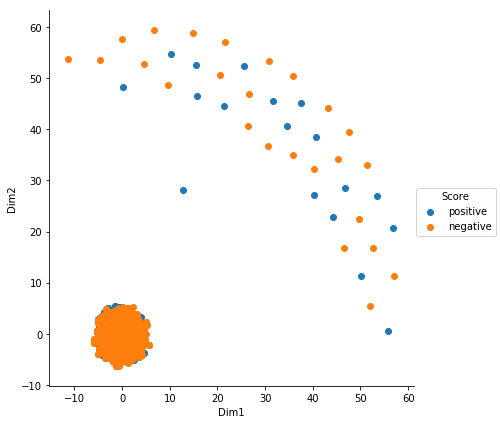

In [6]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = tsne_model.fit_transform(final_bow.todense())

print(type(tsne_data))
print(tsne_data.shape)

tsne_data_plot = np.vstack((tsne_data.T, filtered_data["Score"])).T

plot_df = pd.DataFrame(data=tsne_data_plot, columns=("Dim1", "Dim2","Score"))


sns.FacetGrid(plot_df, hue="Score", size=6) \
  .map(plt.scatter, 'Dim1', 'Dim2') \
  .add_legend()

plt.show()

###### Preplexity = 70

<class 'numpy.ndarray'>
(4000, 2)


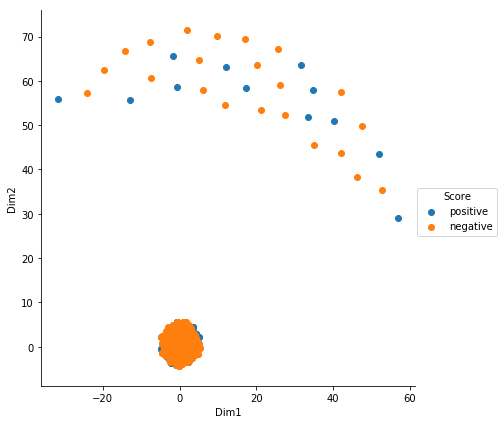

In [10]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=70,  n_iter=5000)

tsne_data = tsne_model.fit_transform(final_bow.todense())

print(type(tsne_data))
print(tsne_data.shape)

tsne_data_plot = np.vstack((tsne_data.T, filtered_data["Score"])).T

plot_df = pd.DataFrame(data=tsne_data_plot, columns=("Dim1", "Dim2","Score"))


sns.FacetGrid(plot_df, hue="Score", size=6) \
  .map(plt.scatter, 'Dim1', 'Dim2') \
  .add_legend()

plt.show()

## T-SNE using Average word2vector

###### Perplexity = 50

<class 'numpy.ndarray'>
(4000, 2)


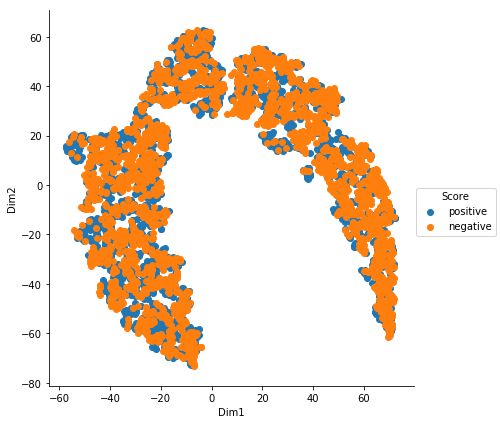

In [9]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)

tsne_data = tsne_model.fit_transform(avg_w2v_vectors)

print(type(tsne_data))
print(tsne_data.shape)

tsne_data_plot = np.vstack((tsne_data.T, filtered_data["Score"])).T

plot_df = pd.DataFrame(data=tsne_data_plot, columns=("Dim1", "Dim2","Score"))


sns.FacetGrid(plot_df, hue="Score", size=6) \
  .map(plt.scatter, 'Dim1', 'Dim2') \
  .add_legend()

plt.show()

###### Perplexity = 30

<class 'numpy.ndarray'>
(4000, 2)


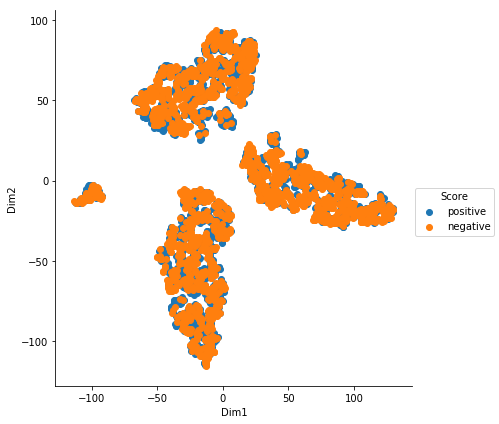

In [11]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=5000)

tsne_data = tsne_model.fit_transform(avg_w2v_vectors)

print(type(tsne_data))
print(tsne_data.shape)

tsne_data_plot = np.vstack((tsne_data.T, filtered_data["Score"])).T

plot_df = pd.DataFrame(data=tsne_data_plot, columns=("Dim1", "Dim2","Score"))


sns.FacetGrid(plot_df, hue="Score", size=6) \
  .map(plt.scatter, 'Dim1', 'Dim2') \
  .add_legend()

plt.show()

## Conclusion

1. The T-SNE is offering no inference with regards to clustering.
2. The positive and negative food reviews are overlapping extensively.
3. There is no iota of clustering based on the sentiment of the reiview.
4. We cannot draw a plane to seperate the +ve reviews from the -ve.
5. We have to use some other models to solve the classification problem.
6. Data is jumbled in all the plots BOW, TFIDF and AVGW2V, TFID-AVGW2V and thus no conclusions can be drawn out of it
7. None of the perplexity values offer any respite